# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [6]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [7]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [8]:
train = train.fillna("")
test = test.fillna("")

In [9]:
test.isna().sum().sum() + train.isna().sum().sum()

0

In [10]:
train.head(5)

,id,keyword,location,text,target
1186,1707,bridge%20collapse,,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
4071,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
5461,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
5787,8257,rioting,,Still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

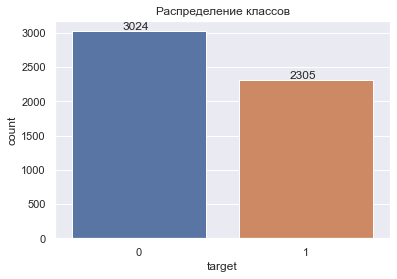

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
ax = sns.countplot(x='target', data=train)
ax.set_title('Распределение классов')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.3, p.get_height()+20))

Судя по описанию на кегле, расклад такой:
+ 1 = твит про катастрофу
+ 0 = твит НЕ про катастрофу

Таким образом заметим, что в общем то классы как бы сбалансировано более менее, но небольшой перевес есть в сторону простотвитов

In [12]:
most_frequent = train[['keyword', 'target']].replace("", np.nan).dropna(subset=['keyword'])['keyword'].value_counts()[:10].index.tolist()
temp_train = train[train['keyword'].isin(most_frequent)]
# вычислим среднее это по сути то же самое, что и доля 1 класса
stair_data = temp_train.groupby(['keyword']).mean().sort_values(by=['target'])
stair_data

,id,target
keyword,,
fear,5287.466667,0.100000
twister,10033.333333,0.100000
siren,8766.628571,0.114286
harm,5907.200000,0.133333
deluge,3177.774194,0.161290
fatality,5236.100000,0.266667
damage,2875.333333,0.472222
fatalities,5188.303030,0.484848
refugees,8032.900000,0.566667


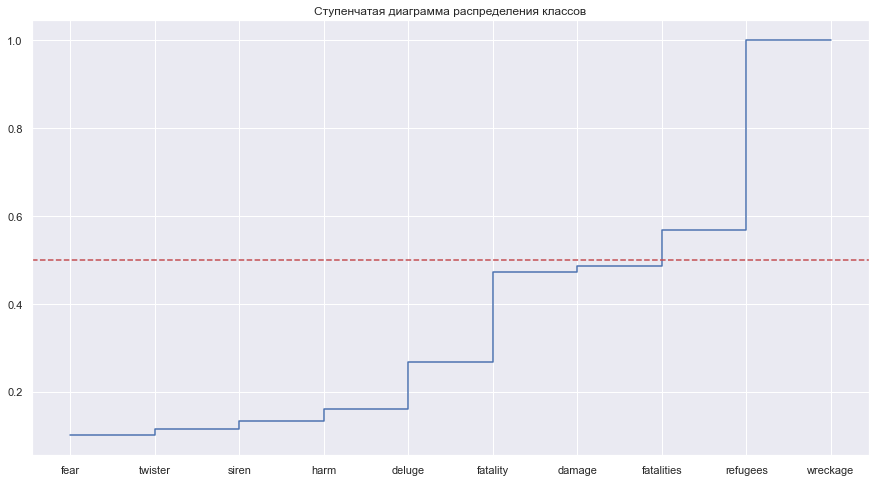

In [13]:
plt.figure(figsize=(15, 8))
plt.step(stair_data.index, stair_data['target'])
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('Ступенчатая диаграмма распределения классов')
plt.show()

заметим, что в большинстве случаев у нас доминирует 0 класс, рассмотрим детальнее и сделаем выводы

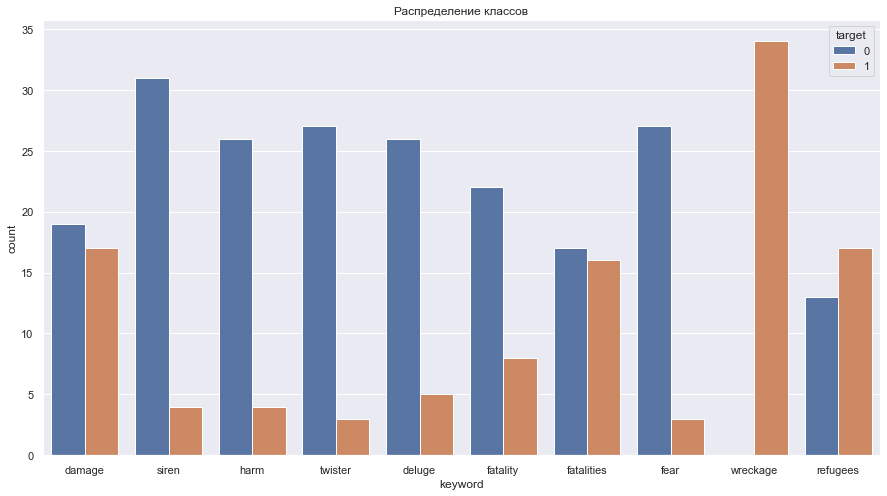

In [14]:
most_frequent = train[['keyword', 'target']].replace("", np.nan).dropna(subset=['keyword'])['keyword'].value_counts()[:10].index.tolist()
temp_train = train[train['keyword'].isin(most_frequent)]
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='keyword', hue='target', data=temp_train)
ax.set_title('Распределение классов')
plt.show()

методом пристального взгляда заметим, что у частых значений есть тенденция в большинстве своем относиться к НЕ катастрофическим твитам

Глянем ка на самые нечастые позиции:

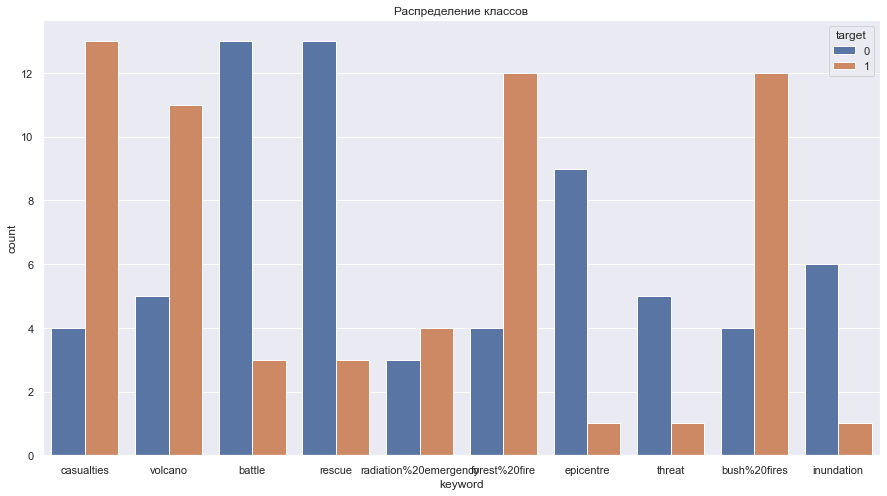

In [15]:
less_frequent = train.replace("", np.nan).dropna(subset=['keyword'])['keyword'].value_counts()[-10:].index.tolist()
temp_train = train[train['keyword'].isin(less_frequent)]
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='keyword', hue='target', data=temp_train)
ax.set_title('Распределение классов')
plt.show()

А тут ситуация почти наоборот, у редких слов примерно равная принадлежность к обоим классам. То есть редкость играет роль. Редкие слова важнее, чтобы отделять 1 класс

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [16]:
train['data'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']
train.drop(columns=['id', 'keyword', 'location', 'text'], inplace=True)
test['data'] = test['keyword'] + ' ' + test['location'] + ' ' + test['text']
test.drop(columns=['id', 'keyword', 'location', 'text'], inplace=True)

In [17]:
train

,target,data
1186,0,bridge%20collapse Ashes 2015: AustraliaÛªs c...
4071,1,"hail Carol Stream, Illinois GREAT MICHIGAN TEC..."
5461,1,police Houston CNN: Tennessee movie theater s...
5787,1,rioting Still rioting in a couple of hours le...
7445,0,wounds Lake Highlands Crack in the path where ...
...,...,...
5226,0,obliteration Merica! @Eganator2000 There aren'...
5390,0,panic just had a panic attack bc I don't have...
860,0,blood Omron HEM-712C Automatic Blood Pressure...
7603,1,Officials say a quarantine is in place at an...


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [18]:
train['data']

1186    bridge%20collapse  Ashes 2015: AustraliaÛªs c...
4071    hail Carol Stream, Illinois GREAT MICHIGAN TEC...
5461    police Houston  CNN: Tennessee movie theater s...
5787    rioting  Still rioting in a couple of hours le...
7445    wounds Lake Highlands Crack in the path where ...
                              ...                        
5226    obliteration Merica! @Eganator2000 There aren'...
5390    panic  just had a panic attack bc I don't have...
860     blood  Omron HEM-712C Automatic Blood Pressure...
7603      Officials say a quarantine is in place at an...
7270    whirlwind Stamford & Cork (& Shropshire) I mov...
Name: data, Length: 5329, dtype: object

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train['data'])

In [20]:
np.random.choice(cnt_vec.get_feature_names_out(), size=20)

array(['l6', 'certified', 'airwaves', 'german', 'fwd', 'permanent',
       'highly', '4izfdyc3cg', 'exclusively', 'tyrant', 'disappears',
       'gc', 'whomever', 'fw1ptaelgv', 'dr_baseball41', 'mort3mer',
       'zqmtrbkas0', 'hinterestin', 'fly', 'catches'], dtype=object)

In [21]:
X.shape

(5329, 18455)

Получилась матрица размера 5329 на 18455

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [22]:
cnt_vec.vocabulary_

{'bridge': 2948,
 '20collapse': 320,
 'ashes': 1928,
 '2015': 295,
 'australia': 2059,
 'ûªs': 18425,
 'collapse': 3914,
 'at': 1977,
 'trent': 16483,
 'among': 1628,
 'worst': 17813,
 'in': 8314,
 'history': 7773,
 'england': 5722,
 'bundled': 3085,
 'out': 11995,
 'for': 6503,
 '60': 755,
 'http': 7970,
 'co': 3861,
 't5trhjuau0': 15733,
 'hail': 7420,
 'carol': 3363,
 'stream': 15419,
 'illinois': 8249,
 'great': 7206,
 'michigan': 10594,
 'technique': 15888,
 'camp': 3261,
 'b1g': 2147,
 'thanks': 16013,
 'to': 16272,
 'bmurph1019': 2753,
 'hail_youtsey': 7421,
 'termn8r13': 15949,
 'goblue': 7088,
 'wrestleon': 17848,
 'oaskgki6qj': 11648,
 'police': 12634,
 'houston': 7933,
 'cnn': 3854,
 'tennessee': 15932,
 'movie': 10940,
 'theater': 16025,
 'shooting': 14647,
 'suspect': 15632,
 'killed': 9246,
 'by': 3150,
 'di8elzswnr': 4890,
 'rioting': 13800,
 'still': 15357,
 'couple': 4204,
 'of': 11708,
 'hours': 7925,
 'left': 9644,
 'until': 16884,
 'have': 7546,
 'be': 2383,
 'up': 

In [23]:
%%time
import re

def analyse(dct):
    print(f"всего слов в словаре: {len(dct)}\n")
    # 1
    total_dig = 0
    count_dig = 0
    for k, v in dct.items():
        if bool(re.search('[0-9]', k)):
            total_dig += v
            count_dig += 1
    print(f"количество слов с цифрами: {count_dig}\n")
    # 2
    total_punct = 0
    count_punct = 0
    for k, v in dct.items():
        if bool(re.search('[^\w\s]', k)):
            total_punct += v
            count_punct += 1
    print(f"количество слов с символами пунктуации: {count_punct}\n")
    """
    total_punct = 0
    count_punct = 0
    from string import punctuation
    # punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    punc = punctuation
    for k, v in dct.items():
        for ele in k:
            if ele in punc:
                total_punct += v
                count_punct += 1
                break
    # тут не совсем символы пунктуации, но тут выходит 315 слова (из-за "_")
    print(f"количество слов с символами пунктуации: {count_punct}\n")
    """
    # 3
    total_tag = 0
    count_tag = 0
    for k, v in dct.items():
        if bool(re.match('#', k)):
            total_tag += v
            count_tag += 1
    print(f"количество слов с хештегом #: {count_tag}\n")
    total_call = 0
    count_call = 0
    for k, v in dct.items():
        if bool(re.match('@', k)):
            total_call += v
            count_call += 1
    print(f"количество слов с упоминанием @: {count_call}\n")
    
    

analyse(cnt_vec.vocabulary_)

всего слов в словаре: 18455

количество слов с цифрами: 3812

количество слов с символами пунктуации: 0

количество слов с хештегом #: 0

количество слов с упоминанием @: 0

Wall time: 80 ms


In [24]:
temp_vec = CountVectorizer()
X_temp = temp_vec.fit_transform(['obliteration Merica! @Eganator2000',
                                'another #hash'])
pd.DataFrame(X_temp.toarray(),
             columns=temp_vec.get_feature_names_out())

,another,eganator2000,hash,merica,obliteration
0,0,1,0,1,1
1,1,0,1,0,0


Так и есть, встроенный токенизатор убирает какие-то лишние вещи - это не очень хорошо в нашем случае, ведь в твиттере хештеги добавляют эмоциональный окрас, собачки ничего не значат (наверное), а смайлики лежать основной способ передачи настроения

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [25]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [26]:
help(TweetTokenizer)

Help on class TweetTokenizer in module nltk.tokenize.casual:

class TweetTokenizer(builtins.object)
 |  TweetTokenizer(preserve_case=True, reduce_len=False, strip_handles=False)
 |  
 |  Tokenizer for tweets.
 |  
 |      >>> from nltk.tokenize import TweetTokenizer
 |      >>> tknzr = TweetTokenizer()
 |      >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
 |      >>> tknzr.tokenize(s0)
 |      ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--']
 |  
 |  Examples using `strip_handles` and `reduce_len parameters`:
 |  
 |      >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
 |      >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
 |      >>> tknzr.tokenize(s1)
 |      [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
 |  
 |  Methods defined here:
 |  
 |  __init__(self, preserve_case=True, reduce_len=False, strip_handles=False)
 |      

- **preserve_case**. By default, it is set to True. If it is set to False, then the tokenizer will downcase everything except for emoticons.

- **reduce_len**. By default, it is set to False. It specifies whether to replace repeated character sequences of length 3 or greater with sequences of length 3.

- **strip_handles**. By default, it is set to False. It specifies whether to remove Twitter handles of text used in the tokenize method.

- **match_phone_numbers**. By default, it is set to True. It indicates whether the tokenize method should look for phone numbers.

Оставим все как есть

In [27]:
cnt_vec_tok = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
X = cnt_vec_tok.fit_transform(train['data'])
X.shape

(5329, 19670)

In [28]:
cnt_vec_tok.vocabulary_

{'bridge': 5275,
 '%': 1472,
 '20collapse': 1800,
 'ashes': 4530,
 '2015': 1773,
 ':': 2229,
 'australia': 4628,
 '\x89': 19587,
 'ûªs': 19640,
 'collapse': 6032,
 'at': 4567,
 'trent': 18450,
 'among': 4300,
 'worst': 19368,
 'in': 12552,
 'history': 8949,
 'england': 7415,
 'bundled': 5388,
 'out': 14999,
 'for': 8041,
 '60': 2077,
 '...': 1512,
 'http://t.co/t5trhjuau0': 11456,
 'hail': 8661,
 'carol': 5600,
 'stream': 17648,
 ',': 1483,
 'illinois': 12503,
 'great': 8518,
 'michigan': 14071,
 'technique': 18025,
 'camp': 5510,
 'b1g': 4691,
 'thanks': 18124,
 'to': 18284,
 '@bmurph1019': 2490,
 '@hail_youtsey': 2905,
 '.': 1509,
 '@termn8r13': 3718,
 '#goblue': 520,
 '#wrestleon': 1442,
 'http://t.co/oaskgki6qj': 10996,
 'police': 15494,
 'houston': 9082,
 'cnn': 5982,
 'tennessee': 18063,
 'movie': 14348,
 'theater': 18131,
 'shooting': 17007,
 'suspect': 17851,
 'killed': 13124,
 'by': 5442,
 'http://t.co/di8elzswnr': 9897,
 'rioting': 16377,
 'still': 17597,
 'a': 3943,
 'couple

In [29]:
analyse(cnt_vec_tok.vocabulary_)

всего слов в словаре: 19670

количество слов с цифрами: 3939

количество слов с символами пунктуации: 7312

количество слов с хештегом #: 1470

количество слов с упоминанием @: 1679



## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [30]:
from nltk.stem.snowball import SnowballStemmer
import nltk

stemmer = SnowballStemmer('english')

In [31]:
%%time

class MyTokenizer:
    def __init__(self):
        self.tokenizer = TweetTokenizer()
        self.stemmer = SnowballStemmer('english')
    
    def my_tokenize(self, text):
        # 0
        text = text.lower()
        # 1
        tokens = self.tokenizer.tokenize(text)
        # 2 + 3 + 4
        result = []
        for token in tokens:
            # 2 (латинские буквы) или (пунктуация и скобочка) или (# и латинские буквы)
            if bool(re.match('[A-Za-z]+', token) or
                    re.match('#[A-Za-z]+', token) or
                    any([re.match(f'[^\w\s]+\{skob}', token) for skob in '({[]})']) or
                    any([re.match(f'\{skob}+[^\w\s]+', token) for skob in '({[]})'])
                   ):
                # 3
                if token not in nltk.corpus.stopwords.words('english'):
                    # 4
                    result.append(self.stemmer.stem(token))
        return result

MyTokenizer().my_tokenize('Somebody once 123 told1me :) or :[')

Wall time: 7 ms


['somebodi', 'told', ':)', ':[']

In [32]:
for i in train.iloc[:10]['data']:
    print(f'{i}\n\n{MyTokenizer().my_tokenize(i)}')
    print('_'*50)

bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia', 'http://t.co/t5trhjuau0']
__________________________________________________
hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj

['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'b1g', 'thank', '#goblu', '#wrestleon', 'http://t.co/oaskgki6qj']
__________________________________________________
police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR

['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic', 'http://t.co/di8elzswnr']
__________________________________________________
rioting  Still

Вроде все работает :)

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [33]:
y_train = train['target']
y_test = test['target']

In [34]:
vec_my_tok = CountVectorizer(tokenizer=MyTokenizer().my_tokenize)
X_train = vec_my_tok.fit_transform(train['data'])
X_test = vec_my_tok.transform(test['data'])

In [35]:
vec_my_tok.vocabulary_

{'bridg': 2465,
 'ash': 1868,
 'australia': 1949,
 'collaps': 3073,
 'trent': 13509,
 'among': 1695,
 'worst': 14246,
 'histori': 5323,
 'england': 4107,
 'bundl': 2562,
 'http://t.co/t5trhjuau0': 7799,
 'hail': 5097,
 'carol': 2728,
 'stream': 12899,
 'illinoi': 8820,
 'great': 4975,
 'michigan': 10084,
 'techniqu': 13183,
 'camp': 2662,
 'b1g': 2001,
 'thank': 13260,
 '#goblu': 478,
 '#wrestleon': 1386,
 'http://t.co/oaskgki6qj': 7339,
 'polic': 11246,
 'houston': 5426,
 'cnn': 3030,
 'tennesse': 13215,
 'movi': 10305,
 'theater': 13265,
 'shoot': 12410,
 'suspect': 13039,
 'kill': 9313,
 'http://t.co/di8elzswnr': 6240,
 'riot': 11902,
 'still': 12861,
 'coupl': 3272,
 'hour': 5422,
 'left': 9524,
 'class': 2981,
 'wound': 14251,
 'lake': 9431,
 'highland': 5289,
 'crack': 3291,
 'path': 10996,
 'wipe': 14171,
 'morn': 10271,
 'beach': 2135,
 'run': 12035,
 'surfac': 13022,
 'elbow': 4021,
 'right': 11891,
 'knee': 9347,
 'http://t.co/yaqrsximph': 8263,
 'airplan': 1588,
 'somewher':

Огонь, вроде все работает

In [36]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7549597855227883


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [37]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=MyTokenizer().my_tokenize)
X_train = tfidf.fit_transform(train['data'])
X_test = tfidf.transform(test['data'])

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7398015435501654
Wall time: 41.6 s


Качество чуть чуть ухудшилось, попробуем подкрутить и посмотрим что из этого выйдет

In [38]:
%%time
tfidf_max = TfidfVectorizer(tokenizer=MyTokenizer().my_tokenize,
                        max_df=0.9)
X_train = tfidf_max.fit_transform(train['data'])
X_test = tfidf_max.transform(test['data'])

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7398015435501654
Wall time: 41.8 s


Почему-то ничего не изменилось 

In [39]:
len(tfidf.vocabulary_)

14432

In [40]:
len(tfidf_max.vocabulary_)

14432

Потому что ограничение не сработало. Попробуем еще подвигать верхнюю границу, но мне кажется результат это не починит (будут действительно важные и частые слова, а не просто частые слова)

In [41]:
%%time
tfidf_max = TfidfVectorizer(tokenizer=MyTokenizer().my_tokenize,
                        max_df=0.01)
X_train = tfidf_max.fit_transform(train['data'])
X_test = tfidf_max.transform(test['data'])

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.6894158473105841
Wall time: 41.1 s


In [42]:
len(tfidf_max.vocabulary_)

14305

Поэкспериментировав, я заметил, что до 0.05 слова не отбрасываются вовсе (это как раз и говорит о подтверждении гипотезы, что суперчастых слов-паразитов в токенах нет). А вариант с минимальным ограничением сверху (чтобы оно реально что-то не пускало) показал такое себе качество, ниже базового точно. То есть были отброшены самые встречающиеся в корпусе слова, но это слова не настолько частые, чтобы захламлять корпус

In [43]:
%%time
tfidf_max_min = TfidfVectorizer(tokenizer=MyTokenizer().my_tokenize,
                        max_df=0.9,
                        min_df=5*1e-4)
X_train = tfidf_max_min.fit_transform(train['data'])
X_test = tfidf_max_min.transform(test['data'])

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7462850853054486
Wall time: 42.6 s


In [44]:
len(tfidf_max_min.vocabulary_)

3213

Звучит уже неплохо, размер матрички уменьшили в 4.5 раза, а в качестве прибавили (относительно голого решения). А относительно самого лучшего решения не сильно отстали!

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [45]:
%%time
from sklearn.feature_extraction.text import HashingVectorizer

hash_vec = HashingVectorizer(tokenizer=MyTokenizer().my_tokenize,
                             n_features=5000)
X_train = hash_vec.fit_transform(train['data'])
X_test = hash_vec.transform(test['data'])

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

D:\anacond\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7180910099889012
Wall time: 41.1 s


Ну в целом неплохо, но могло быть и лучше (я предвкушал, что будет лучше)

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

Лучший из имеющихся результатов дал CountVectorizer, поэтому сначала попробуем все отскалировать, а потом докрутим CountVectorizer.

In [46]:
from sklearn.preprocessing import MaxAbsScaler

vec_my_tok = CountVectorizer(tokenizer=MyTokenizer().my_tokenize)
X_train = vec_my_tok.fit_transform(train['data'])
X_test = vec_my_tok.transform(test['data'])

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7441601779755285


In [47]:
%%time
tfidf_max_min = TfidfVectorizer(tokenizer=MyTokenizer().my_tokenize,
                                min_df=3*1e-4)
X_train = tfidf_max_min.fit_transform(train['data'])
X_test = tfidf_max_min.transform(test['data'])

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7498637602179836
Wall time: 45 s


Было близко, но не пошло :(

In [48]:
vec_my_tok = CountVectorizer(tokenizer=MyTokenizer().my_tokenize,
                             min_df=5*1e-4)
X_train = vec_my_tok.fit_transform(train['data'])
X_test = vec_my_tok.transform(test['data'])

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7566418703506906


Так, ну ограничение снизу (min_df) уже немножко помогло утвердиться в скоре больше 0.75. НО не стоит забываться про n-граммы

In [49]:
vec_my_tok = CountVectorizer(tokenizer=MyTokenizer().my_tokenize,
                             min_df=5*1e-4,
                             ngram_range=(1, 2))
X_train = vec_my_tok.fit_transform(train['data'])
X_test = vec_my_tok.transform(test['data'])

clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7498666666666666


Увы и ах, n-граммы не спасли ситуацию. Грустно, что не смог улучшить, но необходимый скор по итогу был выбит. Мем прилагается

In [52]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.fillna("")
test = test.fillna("")

train['data'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']
train.drop(columns=['keyword', 'location', 'text'], inplace=True)
test['data'] = test['keyword'] + ' ' + test['location'] + ' ' + test['text']
test.drop(columns=['keyword', 'location', 'text'], inplace=True)

y_train = train['target']

In [58]:
vec_my_tok = CountVectorizer(tokenizer=MyTokenizer().my_tokenize)
X_train = vec_my_tok.fit_transform(train['data'])
X_test = vec_my_tok.transform(test['data'])

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
# print(f1_score(y_test, pred))

In [59]:
pred

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [60]:
sub = pd.DataFrame()
sub['id'] = test['id']
sub['target'] = pred
sub['id'] = sub['id'].apply(lambda x: int(x))
sub.to_csv('submission.csv',index=False)

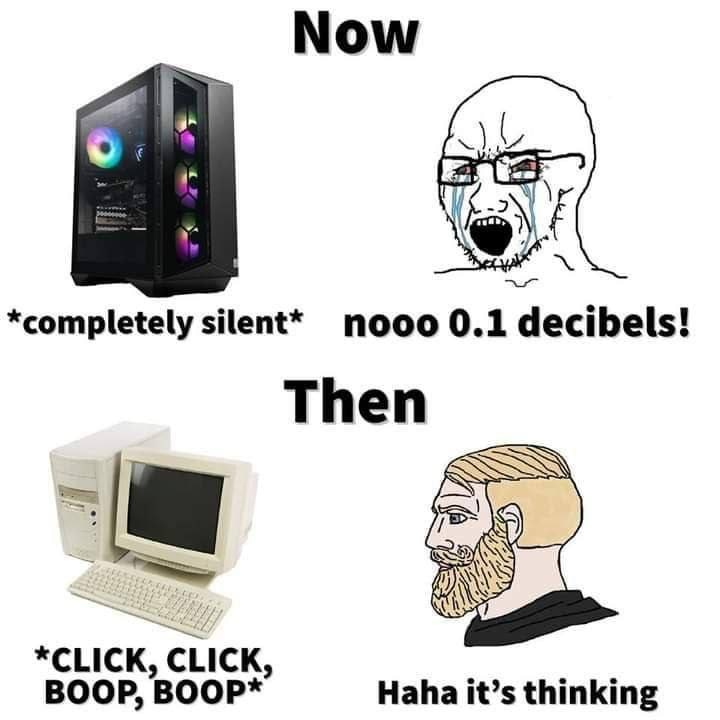